## Sagnac Frequency - Backscatter Correction - RU shortterm

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [4]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2024-03-26 12:00")
config['tend'] = UTCDateTime("2024-03-31 00:00")
flim1, flim2 = 302.42, 302.50

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_00:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_01:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_02:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_03:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_04:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_05:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240401_06:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagn

### Compute Backscatter (again)

In [6]:
from functions.backscatter_correction import __backscatter_correction

In [7]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, 303.05, cm_filter_factor=1.033)

(302.42, 302.5)

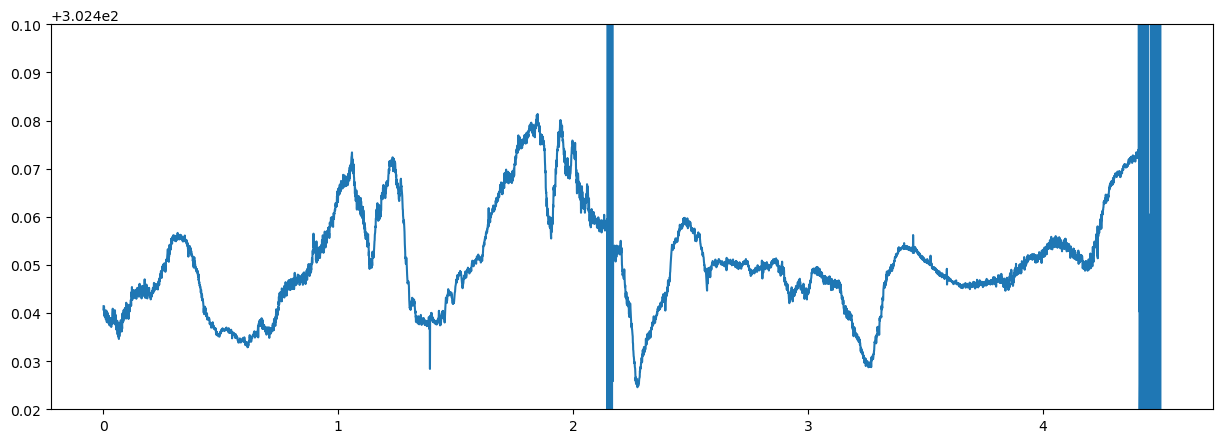

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [9]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [10]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [11]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [12]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

### Apply special filter sections

In [13]:
tt1, tt2 = "2023-11-01", "2023-11-07 17:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.95
cond4 = bs.fj_fs_nan > 303.1

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [14]:
tt1, tt2 = "2023-11-07 17:00", "2023-11-20 14:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.7
cond4 = bs.fj_fs_nan > 303.0

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [15]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [16]:
tt1, tt2 = "2023-12-20 00:00", "2024-02-22"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.38
cond4 = bs.fj_fs_nan > 302.48

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [17]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [18]:
from functions.smoothing import __smooth

n_minutes = 300

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [19]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [20]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_341293/4222311973.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


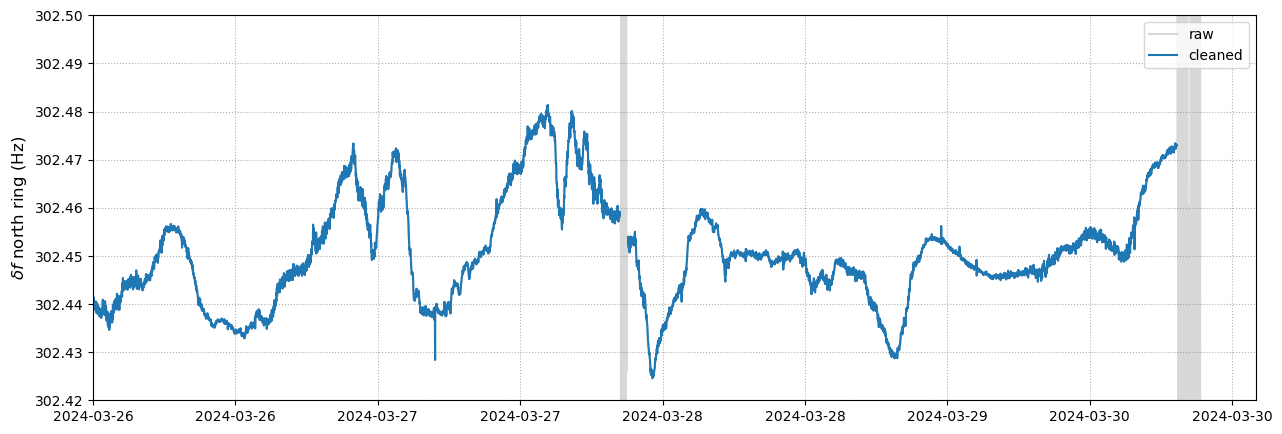

In [21]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Load WROMY Data

In [ ]:
ws = Stream()
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

ws = ws.merge();

ws

### Load PROMY Data

In [ ]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

### Load Rain Data

In [ ]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [ ]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

In [ ]:
rain = furt.select(channel="LAR")

# smoothed precipitation
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

# cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)

### Load Tilt Data

In [ ]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [ ]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

# tromy0 =  __read_sds(path_to_tilt, "BW.TROMY..MAN", config['tbeg']+17*86400-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAE", config['tbeg']+17*86400-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAT", config['tbeg']+17*86400-600, config['tend']+600)

path_to_tilt = archive_path+"romy_archive/"

tromy0 =  __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

In [ ]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

### Load Water Level Data

In [ ]:
from functions.load_water_level import __load_water_level

In [ ]:
pegel =  __load_water_level(config['tbeg'], config['tend'])

## remove error measurements with nan
pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

pegel

### Load Beam Wander Data

In [ ]:
from functions.load_beam_wander_data import __load_beam_wander_data

In [ ]:
bw = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+"ids/data/")

In [ ]:
bw = bw[(bw.time > config['tbeg']) & (bw.time < config['tend'])]

bw.time_utc = np.array([UTCDateTime(_t) for _t in bw.time])

bw['x_mm'] = bw.x*1.67e-3
bw['y_mm'] = bw.y*1.67e-3

bw['x_mm'] = bw.x_mm - bw.x_mm.iloc[0]
bw['y_mm'] = bw.y_mm - bw.y_mm.iloc[0]

### Load Infrasound FFBI

In [ ]:
ffbi = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BD*", config['tbeg'], config['tend'])

if len(ffbi) != 2:
    ffbi.merge();

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")
ffbi = ffbi.remove_response(ffbi_inv, water_level=10)

ffbi.plot(equal_scale=False);

## Plotting

In [ ]:
def __makeplot():

    Nrow, Ncol = 6, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    ref_date = bs.time1.iloc[0]

    # _____________________________________________________________________________________
    #
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="red", label=f"BS corrected")

    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    # _____________________________________________________________________________________
    #
    for tr in ws.select(channel="*T"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=UTCDateTime(ref_date)),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"WS{num}", alpha=0.7)

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=UTCDateTime(ref_date)),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"PS{num}", alpha=0.7)

    ax[1].set_ylim(10, 12)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.plot(ps.select(location="01", channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
              __smooth(ps.select(location="01", channel="*KI")[0].data, 600), color=config['colors'][1], label="PS1")

    ax11.set_ylabel("Temperature (°C)", fontsize=font, color=config['colors'][1])
    [t.set_color(config['colors'][1]) for t in ax11.yaxis.get_ticklabels()]
    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))



    # _____________________________________________________________________________________
    #
    ax[2].spines.right.set_position(("axes", 1.07))
    # ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel, color="darkblue", alpha=0.9)
    # ax[2].set_ylabel(f"Water Level (m)", fontsize=font)

    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=UTCDateTime(ref_date)),
                      rain_smooth, color="tab:blue", alpha=0.6, label=f"rain", zorder=0)
    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Precipitation \n (mm/hour)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))


    ax24 = ax[2].twinx()
    ax24.plot(rain_cumsum/max(rain_cumsum), alpha=0.5, zorder=1, ls="--")
    ax24.axis('off')
    # ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    # [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]
    # ax24.set_ylabel(f"Cum. Rain (mm)", fontsize=font, color="darkblue")


    # _____________________________________________________________________________________
    #
    ax[3].plot(tromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
               __smooth(__reduce(tromy.select(channel="*N")[0].data, 100), 60)[:-20]*1e6, label="TROMY N-S (1 min. avg.)", color="tab:orange")
    ax[3].plot(tromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
               __smooth(__reduce(tromy.select(channel="*E")[0].data, 100), 60)[:-20]*1e6, label="TROMY E-W (1 min. avg.)", color="tab:brown")
    ax[3].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[3].set_ylim(-10, 5)

    # _____________________________________________________________________________________
    #
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ffbi.select(channel="*F")[0].data, 600),
               label=f"{ffbi.select(channel='*F')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (10 min. avg.)",
               color="tab:red"
              )
    ax[4].set_ylabel("Pressure (Pa)", fontsize=font)
    # ax[4].set_ylim(-, 6)

    ax41 = ax[4].twinx()
    ax41.plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
              ffbi.select(channel="*O")[0].data,
              label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (10 min. avg.)",
              color="black"
              )
    # _____________________________________________________________________________________
    #
    ax[5].scatter(bw.time_utc - UTCDateTime(ref_date),
                  bw.x_mm*1e3,
                  label=f"in-plane",
                  color="tab:pink",
                  zorder=2,
                  s=5,
              )
    ax[5].scatter(bw.time_utc - UTCDateTime(ref_date),
                  bw.y_mm*1e3,
                  label=f"out-of-plane",
                  color="purple",
                  zorder=2,
                  s=5,
              )
    ax[5].set_ylabel("rel. Beam \n Position ($\mu$m)", fontsize=font)
    ax[5].set_ylim(-5, 20)


    # _____________________________________________________________________________________
    #
    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, alpha=0.5)


    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=1, ncol=1)
    # ax[2].legend(loc=2, ncol=1)
    ax[3].legend(loc=3, ncol=1)
    ax[4].legend(loc=3, ncol=1)
    ax[5].legend(loc=2, ncol=1)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_environmentals_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')
